In [2]:
!pip install torchinfo
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that 

### 데이터 로드 및 준비

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
import os

# Wandb API Key 설정 (필요한 경우 API Key를 자신의 Key로 설정)
os.environ["WANDB_API_KEY"] = "b4b06c1cfe37299ec40b433d0a4c2b1052806ec6"

# 데이터 로드 함수 (훈련 및 검증 데이터)
def get_fashion_mnist_data():
    """
    Fashion MNIST 데이터셋 로드 및 훈련/검증 데이터 분리 함수.
    - 데이터셋: Fashion MNIST (PyTorch 내장 데이터셋)
    - 훈련 데이터와 검증 데이터를 55,000:5,000 비율로 분리
    - DataLoader를 사용하여 데이터 배치 생성

    Returns:
        train_data_loader (DataLoader): 훈련 데이터 로더
        validation_data_loader (DataLoader): 검증 데이터 로더
    """
    data_path = "./data"  # 데이터 저장 경로
    f_mnist_train = datasets.FashionMNIST(
        root=data_path, 
        train=True, 
        download=True, 
        transform=transforms.ToTensor()
    )
    
    # 훈련 및 검증 데이터셋 분리 (55,000:5,000 비율)
    f_mnist_train, f_mnist_validation = random_split(
        dataset=f_mnist_train, 
        lengths=[55000, 5000]
    )
    
    # DataLoader 생성
    train_data_loader = DataLoader(dataset=f_mnist_train, batch_size=64, shuffle=True)
    validation_data_loader = DataLoader(dataset=f_mnist_validation, batch_size=64)

    return train_data_loader, validation_data_loader


# 데이터 로드 함수 (테스트 데이터)
def get_fashion_mnist_test_data():
    """
    Fashion MNIST 테스트 데이터셋 로드 함수.
    - 데이터셋: Fashion MNIST (PyTorch 내장 데이터셋)
    - DataLoader를 사용하여 데이터 배치 생성

    Returns:
        test_data_loader (DataLoader): 테스트 데이터 로더
    """
    data_path = "./data"  # 데이터 저장 경로
    f_mnist_test = datasets.FashionMNIST(
        root=data_path, 
        train=False, 
        download=True, 
        transform=transforms.ToTensor()
    )

    # DataLoader 생성
    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=64)

    return test_data_loader


# 데이터 로드 및 개수 출력
if __name__ == "__main__":
    # 훈련 및 검증 데이터 로드
    train_loader, val_loader = get_fashion_mnist_data()
    
    # 테스트 데이터 로드
    test_loader = get_fashion_mnist_test_data()
    
    # 데이터셋 크기 출력
    print(f"Data loaded: {len(train_loader.dataset)} training samples, {len(val_loader.dataset)} validation samples.")
    print(f"Test Data loaded: {len(test_loader.dataset)} test samples.")


Data loaded: 55000 training samples, 5000 validation samples.
Test Data loaded: 10000 test samples.


### 모델 정의

In [4]:
import torch.nn as nn
from torchinfo import summary

# CNN 모델 정의
class FashionMNIST_CNN(nn.Module):
    """
    Fashion MNIST를 위한 CNN 모델 정의
    """
    def __init__(self, dropout_rate=0.55):
        super(FashionMNIST_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2), # 최대 풀링 계층
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(), # 데이터를 1차원으로 변환
            nn.Linear(128 * 7 * 7, 256), nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10) # 출력 계층: 10개의 클래스
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 모델 초기화 및 구조 출력
model = FashionMNIST_CNN(dropout_rate=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNIST_CNN                         [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─BatchNorm2d: 2-3                  [64, 32, 28, 28]          64
│    └─Conv2d: 2-4                       [64, 64, 28, 28]          18,496
│    └─ReLU: 2-5                         [64, 64, 28, 28]          --
│    └─BatchNorm2d: 2-6                  [64, 64, 28, 28]          128
│    └─MaxPool2d: 2-7                    [64, 64, 14, 14]          --
│    └─Dropout: 2-8                      [64, 64, 14, 14]          --
│    └─Conv2d: 2-9                       [64, 128, 14, 14]         73,856
│    └─ReLU: 2-10                        [64, 128, 14, 14]         --
│    └─BatchNorm2d: 2-11                 [64, 128, 14, 14]         256
│   

### 학습 및 검증

In [52]:
import torch.optim as optim
import wandb

wandb.init(
    project="fashion-mnist", 
    name="cnn-fmnist-run", 
    config={
        "epochs": 20,
        "batch_size": 64,
        "learning_rate": 0.0005,
        "dropout_rate": 0.4,
        "weight_decay": 1e-4
    }
)

# 학습 및 검증 함수
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    """
    CNN 모델을 학습하고 검증하는 함수
    """
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == targets).sum().item()

        train_accuracy = train_correct / len(train_loader.dataset)
        
        # 검증
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Wandb 로깅
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss / len(train_loader),
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": scheduler.get_last_lr()[0]
        })
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth") # 최적 모델 저장
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 학습
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)


Epoch 1/20, Train Loss: 0.1788, Val Loss: 0.1743, Val Accuracy: 0.9350
Epoch 2/20, Train Loss: 0.1740, Val Loss: 0.1800, Val Accuracy: 0.9354
Epoch 3/20, Train Loss: 0.1630, Val Loss: 0.1682, Val Accuracy: 0.9358
Epoch 4/20, Train Loss: 0.1563, Val Loss: 0.1626, Val Accuracy: 0.9388
Epoch 5/20, Train Loss: 0.1466, Val Loss: 0.1701, Val Accuracy: 0.9376
Epoch 6/20, Train Loss: 0.1165, Val Loss: 0.1558, Val Accuracy: 0.9450
Epoch 7/20, Train Loss: 0.1035, Val Loss: 0.1565, Val Accuracy: 0.9458
Epoch 8/20, Train Loss: 0.0967, Val Loss: 0.1578, Val Accuracy: 0.9456
Epoch 9/20, Train Loss: 0.0912, Val Loss: 0.1584, Val Accuracy: 0.9446
Epoch 10/20, Train Loss: 0.0885, Val Loss: 0.1596, Val Accuracy: 0.9462
Epoch 11/20, Train Loss: 0.0808, Val Loss: 0.1587, Val Accuracy: 0.9458
Early stopping triggered.


### 테스트 평가

In [55]:
# 평가 함수
def evaluate(model, data_loader, criterion):
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).sum().item()

    val_accuracy = correct / len(data_loader.dataset)
    return val_loss / len(data_loader), val_accuracy

# 테스트 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1849, Test Accuracy: 0.9426


### 샘플 예측 시각화

Misclassified: True Label=7, Predicted=9


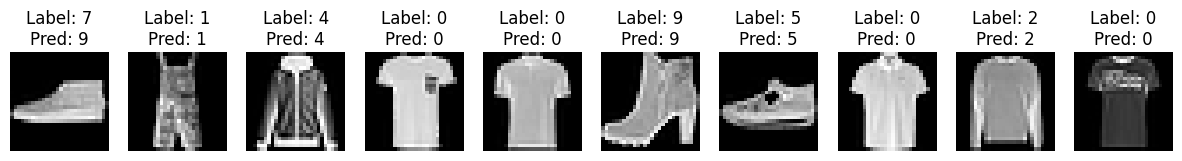

In [72]:
import matplotlib.pyplot as plt
import random

# 샘플 테스트 데이터 분류 예측
def test_sample_predictions(model, test_loader, num_samples=10):
    """
    테스트 데이터에서 샘플 이미지를 선택하고, 예측 결과를 시각화
    """
    model.eval()

    all_images = []
    all_labels = []
    for inputs, targets in test_loader:
        all_images.append(inputs)
        all_labels.append(targets)

    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # 샘플 선택
    indices = random.sample(range(len(all_images)), num_samples)
    selected_images = all_images[indices].to(device)
    selected_labels = all_labels[indices].to(device)

    # 예측
    outputs = model(selected_images)
    predictions = outputs.argmax(1)

    # 시각화
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axs):
        image = selected_images[i].cpu().squeeze().numpy()
        label = selected_labels[i].item()
        prediction = predictions[i].item()

        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}\nPred: {prediction}")
        if label != prediction:
            print(f"Misclassified: True Label={label}, Predicted={prediction}")

    plt.show()

# 샘플 데이터 예측
test_sample_predictions(model, test_loader, num_samples=10)


해당 사례에서 모델이 snaekers를 ankle boot로 분류한 이유는 크게 세 가지로 나눌 수 있을 것 같습니다. 

먼저, 이미지 품질 및 특징 부족이 주요 원인으로 보입니다. 패션 MNIST 데이터는 해상도가 낮아 sneakers의 세부적인 구조적 특징이 충분히 드러나지 않을 수 있어서 그런 것 같습니다.

둘째로, 모델의 일반화 성능 부족도 원인으로 파악됩니다. 훈련 데이터에서 운동화와 샌들을 명확히 구분할 수 있는 충분한 사례가 포함되지 않았을 가능성이 있습니다. 특히 두 클래스가 공유하는 특징을 학습하는 과정에서 모델이 혼란을 겪었을 수 있을 것 같습니다.

셋째로, 데이터 증강 방식이 오히려 혼동을 초래했을 가능성이 있는 것 같습니다. 본 모델은 회전 및 수평 뒤집기 같은 데이터 증강을 활용했는데, 이러한 증강은 snaekers와 ankle boot의 시각적 유사성을 증가시키는 결과를 낳을 수 있습니다. 예를 들어, snaekers와 ankle boot는 회전이나 뒤집기 후에도 비슷한 실루엣을 유지하므로 모델이 주요 특징을 학습하지 못했을 가능성이 있는 것 같습니다.

### 취득한 기술적 사항/고찰

1. CNN 모델 구성 및 데이터 증강 기술

기술적 사항:
CNN 계층을 구성하면서 컨볼루션, 배치 정규화, 드롭아웃 등 다양한 기법을 활용하여 모델의 과적합을 방지하고 성능을 향상시킬 수 있음을 확인했습니다.
데이터 증강 기법으로 랜덤 회전, 수평 뒤집기 등을 적용하여 모델의 일반화 성능을 높이는 데 기여했습니다.

고찰:
데이터 증강이 모델의 일반화에 미치는 긍정적인 영향을 체감했으나, 경우에 따라 과도한 증강이 특정 클래스 간 혼동을 증가시킬 수 있다는 점을 알게 되었습니다. 증강 기법 선택은 데이터셋의 특성에 따라 신중히 이루어져야 함을 느꼈습니다.

2. 모델 성능 평가 및 시각화

기술적 사항:
학습 및 검증 데이터의 손실 값과 정확도를 주기적으로 로깅하고, 테스트 데이터의 정확도를 시각화하여 학습 진행 상황을 체계적으로 파악했습니다.
Matplotlib를 사용해 잘못 분류된 샘플을 시각적으로 분석하며 모델의 한계점을 발견했습니다.

고찰:
시각화를 통해 잘못 분류된 사례를 직접 확인함으로써 모델 개선에 필요한 구체적인 방향성을 설정할 수 있었습니다. 예를 들어, 운동화와 샌들 간 혼동 문제를 해결하기 위해 세부 특징 학습을 강화할 필요성을 인지했습니다.

3. Wandb 활용한 실험 추적 및 관리

기술적 사항:
Wandb를 사용하여 학습률, 손실, 정확도 등 주요 지표를 효과적으로 관리하고, 다양한 실험 결과를 저장 및 비교할 수 있었습니다.
학습률 스케줄링(StepLR)을 적용하며 최적의 학습률을 찾는 과정에서 Wandb가 큰 도움을 주었습니다.

고찰:
Wandb는 실험 결과를 체계적으로 관리할 수 있는 훌륭한 도구임을 체감했습니다. 다만, 설정이 다소 복잡하여 처음 사용 시 적응이 필요했고, 실험 기록의 중요성을 깨달으며 코드와 실험 로그의 일관성을 유지하는 것이 중요하다고 느꼈습니다.

4. 오분류 사례 분석 및 개선 방안 도출

기술적 사항:
오분류된 사례를 확인하고, 모델이 잘못된 예측을 하게 된 원인을 데이터 품질, 모델 구조, 증강 방식 등 다양한 측면에서 분석했습니다.
해당 사례를 기반으로 모델 구조 변경, 데이터 추가 및 수정, 증강 전략 개선과 같은 해결책을 도출했습니다.

고찰:
머신러닝 프로젝트에서 단순히 높은 정확도를 목표로 하기보다는, 모델의 한계를 분석하고 개선하는 과정이 더 큰 학습으로 이어진다는 점을 체감했습니다. 오분류 사례 분석은 모델 개선을 위한 필수 단계임을 깨달았습니다.

5. 학습률 조정 및 Early Stopping 활용

기술적 사항:
학습률 조정(StepLR)과 Early Stopping을 도입하여 학습 과정에서 불필요한 자원 낭비를 줄이고, 적정한 시점에서 학습을 종료할 수 있었습니다.
이를 통해 과적합을 방지하고 학습 시간을 단축했습니다.

고찰:
Early Stopping은 모델이 검증 데이터에서 더 이상 개선되지 않을 때 유용하지만, 너무 이르게 종료될 경우 최적의 성능을 달성하지 못할 위험도 있다는 점을 느꼈습니다. 학습률 스케줄링과의 조합이 효과적임을 확인했습니다.

### 숙제 후기

이번 숙제를 통해 Fashion MNIST 데이터와 CNN 모델 학습에 대한 실질적인 이해를 깊게 할 수 있었습니다. Validation 및 Test Accuracy 목표를 설정하고 이를 만족시키기 위해 다양한 최적화 및 정규화 기법을 활용하며, 하이퍼파라미터의 중요성을 체감했습니다. 또한, 잘못 분류된 샘플을 분석하며 모델의 한계를 파악하고 개선 방향을 고민할 기회를 얻었습니다.